## Models evaluation

This notebook runs different models on image features extracted from satellite images using the CNN. Models regress to predict prevalence of mental health issues within cities.

In [118]:
import pandas as pd
import numpy as np
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.models import Model, Sequential
import os, sys
import glob
import matplotlib.pyplot as plt
# from PIL import Image
# from PIL import ImageOps
import csv

In [3]:
# Los Angeles

# Loading VGG extracted features
x_lacity = np.loadtxt('./pretrained_output/X_lacity_fc7_vggf_z18.txt')
print(x_lacity.shape)

# Loading target variables
la_df = pd.DataFrame.from_csv('./data/lacity/500_cities_lacity_mental_health.csv')
print(la_df.shape)

(993, 4096)
(994, 14)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  


In [3]:
vgg16_model = VGG16(weights='imagenet', include_top=True)


Instructions for updating:
Colocations handled automatically by placer.


In [4]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [5]:
'''
Image processing helper function
'''
#Size of images
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
imgdir = "./data/lacity/img/*png"

def transform_img(img, img_width=IMAGE_WIDTH, img_height=IMAGE_HEIGHT):

    r,g,b = img.split()
    #Histogram Equalization
    # img[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
    # img[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
    # img[:, :, 2] = cv2.equalizeHist(img[:, :, 2])
    rnew = ImageOps.equalize(r)
    gnew = ImageOps.equalize(g)
    bnew = ImageOps.equalize(b)

    #Image Resizing
    # img = cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC)
    img = Image.merge("RGB", (rnew,gnew,bnew))
    img = img.resize((img_width, img_height), resample = Image.BICUBIC)
    return img

def vis_square(data):
    data = (data - data.min()) / (data.max() - data.min())
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))
               + ((0, 0),) * (data.ndim - 3))
    data = np.pad(data, padding, mode = 'constant', constant_values = 1)

    data = data.reshape((n, n) + data.shape[1:]).transpose((0,2,1,3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    return(data)

## Process images

In [6]:
feature_extract_model = Model(inputs=vgg16_model.input,
                              outputs=vgg16_model.get_layer('fc2').output)

In [ ]:
test_img_paths = [img_path for img_path in glob.glob(imgdir)]

# Extract features
raw_features = []
tractFIPS = []
finalimgs = []
count = 0
split = 0
outdir = './out'
city = 'lacity'

In [ ]:
for img_path in test_img_paths:
    img = image.load_img(img_path, target_size=(224,224))
    img = transform_img(img, img_width = IMAGE_WIDTH, img_height = IMAGE_HEIGHT)
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    features = feature_extract_model.predict(img_data)
    raw_features.append(features)
    finalimgs.append(img_path.split()[-1])
    tractFIPS.append(img_path.split('_')[1])
    count += 1

raw_features = np.vstack(raw_features)
np.save(os.path.join(outdir, city, 'features_tracts_fc7_z18_vgg_' + str(split) + '.npy'), raw_features)
np.save(os.path.join(outdir, city, 'filenames_tracts_fc7_z18_vgg_' + str(split) + '.npy'), finalimgs)

In [ ]:
test_df = pd.DataFrame(raw_features)
tractFIPS = [row.lstrip('0') for row in tractFIPS]
test_df['TractFIPS'] = tractFIPS

In [ ]:
la_df.TractFIPS = la_df.TractFIPS.astype('O')

In [ ]:
test_df.to_csv('la_vgg.csv')

## Training regression model

In [69]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate, GridSearchCV
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge, Lasso, ElasticNet
from sklearn import metrics
from sklearn.svm import SVR
from scipy.stats.stats import pearsonr
X = pd.DataFrame.from_csv('la_vgg.csv').sort_values(by=['TractFIPS']).reset_index().drop(["index"], axis=1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  


## Preparing data

In [70]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,TractFIPS
0,1.535566,1.229616,0.658255,1.507081,2.624575,1.061752,3.536164,-0.0,1.219561,-0.0,...,-0.0,-0.0,-0.0,-0.0,2.447415,0.510135,-0.000000,-0.000000,-0.000000,6037101110
1,1.408049,3.885460,0.551711,-0.000000,8.767652,-0.000000,0.880536,-0.0,-0.000000,-0.0,...,-0.0,-0.0,-0.0,-0.0,0.288755,1.299185,2.104688,-0.000000,0.312325,6037101122
2,1.340590,5.633620,2.135561,1.388060,4.021668,1.746387,0.374989,-0.0,1.078838,-0.0,...,-0.0,-0.0,-0.0,-0.0,1.080878,1.162551,-0.000000,-0.000000,-0.000000,6037101210
3,4.680807,2.878426,1.926969,-0.000000,3.836767,-0.000000,1.900073,-0.0,-0.000000,-0.0,...,-0.0,-0.0,-0.0,-0.0,3.632332,1.926144,-0.000000,3.650725,-0.000000,6037101220
4,2.665981,6.372698,1.211612,1.325631,4.293569,-0.000000,2.716865,-0.0,-0.000000,-0.0,...,-0.0,-0.0,-0.0,-0.0,2.999381,-0.000000,-0.000000,-0.000000,-0.000000,6037101300


In [71]:
target = la_df.sort_values(by="TractFIPS").reset_index().drop(["index"], axis=1)
target.head()

,Year,StateAbbr,StateDesc,CityName,GeographicLevel,UniqueID,DataValueTypeID,Data_Value,Low_Confidence_Limit,High_Confidence_Limit,PopulationCount,GeoLocation,CityFIPS,TractFIPS
0,2016,CA,California,Los Angeles,Census Tract,0644000-06037101110,CrdPrv,13.8,12.6,15.1,"4,731","(34.2594736124, -118.292986888)",644000.0,6037101110
1,2016,CA,California,Los Angeles,Census Tract,0644000-06037101122,CrdPrv,10.7,9.7,11.7,"3,664","(34.2677215381, -118.290147139)",644000.0,6037101122
2,2016,CA,California,Los Angeles,Census Tract,0644000-06037101210,CrdPrv,15.7,14.3,16.9,"5,990","(34.2529723884, -118.29073093)",644000.0,6037101210
3,2016,CA,California,Los Angeles,Census Tract,0644000-06037101220,CrdPrv,14.1,12.9,15.3,"3,363","(34.251608492, -118.281632269)",644000.0,6037101220
4,2016,CA,California,Los Angeles,Census Tract,0644000-06037101300,CrdPrv,11.0,9.8,12.3,"4,199","(34.2487781261, -118.270998916)",644000.0,6037101300


In [72]:
# Check outstanding rows
s = set(target['TractFIPS']).symmetric_difference(set(X['TractFIPS']))
s

{6037930401}

In [73]:
target = target[target.TractFIPS != 6037930401]

In [74]:
print(target.shape, X.shape)

(993, 14) (993, 4097)


## Train on LA and test on LA

In [75]:
y = target.Data_Value
X = X.drop(['TractFIPS'], axis=1)

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [77]:
lasso_model = Lasso()
parameter = {"alpha": [0.01, 0.1, 1, 1.5]}
las_clf = GridSearchCV(lasso_model, parameter, cv=5)
las_clf.fit(X_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 100.72611474808346, tolerance: 0.7361209763779529
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 109.6783211482473, tolerance: 0.7213264629921261
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 109.67232414187939, tolerance: 0.7571831023622049
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 129.3009648

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None, param_grid={'alpha': [0.01, 0.1, 1, 1.5]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [79]:
las_clf.cv_results_

{'mean_fit_time': array([1.47346101, 1.58521228, 0.07564797, 0.07578039]),
 'std_fit_time': array([0.04365597, 0.20771234, 0.00927709, 0.01428849]),
 'mean_score_time': array([0.00255971, 0.00280042, 0.00242314, 0.0025249 ]),
 'std_score_time': array([0.00021778, 0.00027529, 0.00027935, 0.00023059]),
 'param_alpha': masked_array(data=[0.01, 0.1, 1, 1.5],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.01}, {'alpha': 0.1}, {'alpha': 1}, {'alpha': 1.5}],
 'split0_test_score': array([0.00150102, 0.28180221, 0.19852277, 0.12879174]),
 'split1_test_score': array([-0.13833558,  0.36611455,  0.18818118,  0.11512749]),
 'split2_test_score': array([0.05660908, 0.25272031, 0.18677861, 0.13247776]),
 'split3_test_score': array([0.06067536, 0.39296619, 0.23938489, 0.16477676]),
 'split4_test_score': array([-0.16085679,  0.26723918,  0.13211947,  0.07090756]),
 'mean_test_score': array([-0.03592423,  0.31222507,  0.1890690

In [107]:
# Lasso
las_model = Lasso(alpha=0.1)
las_model.fit(X_train, y_train)

# Linear
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# SVR
svr_model = SVR(gamma='scale', C=1.0, epsilon=0.2)
svr_model.fit(X_train, y_train)

print(lr_model.intercept_, lr_model.coef_)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5038836770368107, tolerance: 0.9166011901763225
  positive)


12.536065855676192 [ 0.02912207 -0.03362535  0.05403682 ... -0.03642579  0.03171541
  0.10398077]


In [108]:
y_pred_lr = lr_model.predict(X_test)
y_pred_svr = svr_model.predict(X_test)

In [109]:
true_pred_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_lr})
true_pred_df.head()

,Actual,Predicted
433,14.8,18.172863
58,14.0,17.001035
684,15.4,13.117144
614,13.9,14.987080
281,9.4,11.956714


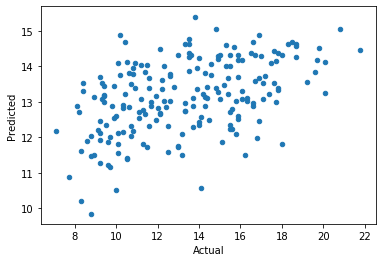

In [83]:
true_pred_df.plot(x='Actual', y='Predicted', kind="scatter")

In [110]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_lr))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_lr))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_lr)))
print('R2:', metrics.r2_score(y_test, y_pred_lr))

Mean Absolute Error: 2.811833567184968
Mean Squared Error: 11.545948537425295
Root Mean Squared Error: 3.3979329801256077
R2: -0.13246655842401478


In [85]:
y_pred_lr = lr_model.predict(X_train)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, y_pred_lr))  
print('Mean Squared Error:', metrics.mean_squared_error(y_train, y_pred_lr))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_lr)))
print('R2:', metrics.r2_score(y_train, y_pred_lr))

Mean Absolute Error: 2.4936142830336308
Mean Squared Error: 8.918910735052762
Root Mean Squared Error: 2.9864545426061255
R2: 0.22740498271995102


In [26]:
true_pred_df_svr = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_svr})
true_pred_df_svr.head()

,Actual,Predicted
128,12.8,10.813125
753,15.9,15.266446
175,16.6,15.006275
970,10.8,15.190196
340,10.3,15.648595


In [47]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_svr))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_svr))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_svr)))
print('R2:', metrics.r2_score(y_test, y_pred_svr))

Mean Absolute Error: 2.2539133756627465
Mean Squared Error: 7.872453838928432
Root Mean Squared Error: 2.8057893432915506
R2: 0.24055537892323176


## Gradient Boosting Trees

In [104]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_gbr))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_gbr))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_gbr)))
print('R2:', metrics.r2_score(y_test, y_pred_gbr))

Mean Absolute Error: 2.213712187600308
Mean Squared Error: 7.257479537738195
Root Mean Squared Error: 2.693970960819399
R2: 0.2881613105848939


In [105]:
y_pred_gbr_train = gbr.predict(X_train)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, y_pred_gbr_train))  
print('Mean Squared Error:', metrics.mean_squared_error(y_train, y_pred_gbr_train))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_gbr_train)))
print('R2:', metrics.r2_score(y_train, y_pred_gbr_train))

Mean Absolute Error: 1.0478737348591654
Mean Squared Error: 1.5921207260628478
Root Mean Squared Error: 1.2617926636586725
R2: 0.8620835462530085


### K-fold

In [150]:
scoring = ['explained_variance', 'r2', 'neg_mean_squared_error']

In [151]:
kfold = KFold(n_splits=5, random_state=42)
results = cross_validate(lr_model, X, y, cv=kfold, scoring=scoring)

In [154]:
results

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_explained_variance'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_r2'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_neg_mean_squared_error'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([0.15501094, 0.11206985, 0.13935685, 0.13656688, 0.12068105]),
 'score_time': array([0.00471187, 0.00417519, 0.00409698, 0.00497007, 0.00557494]),
 'test_explained_variance': array([ 0.09476348,  0.11429798, -0.07783324,  0.18347151,  0.15243254]),
 'train_explained_variance': array([0.34635403, 0.33319477, 0.38323875, 0.25718806, 0.31201466]),
 'test_r2': array([ 0.0844247 , -0.10987472, -0.08122855, -0.20920419, -0.01293109]),
 'train_r2': array([0.34635403, 0.33319477, 0.38323875, 0.25718806, 0.31201466]),
 'test_neg_mean_squared_error': array([ -6.72324047,  -6.82868438, -10.14418232, -13.5870567 ,
        -14.37673135]),
 'train_neg_mean_squared_error': array([-8.02478725, -8.00202879, -7.23926017, -7.22994163, -7.0218529 ])}

In [155]:
kfold = KFold(n_splits=5, random_state=42)
results = cross_validate(svr_model, X, y, cv=kfold, scoring=scoring)
results

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_explained_variance'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_r2'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_neg_mean_squared_error'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([3.22312713, 3.51311612, 3.13985586, 3.20719218, 3.01713586]),
 'score_time': array([2.34534597, 2.67100596, 2.12981033, 2.99375796, 2.25244808]),
 'test_explained_variance': array([ 0.03523648,  0.09235473, -0.1873359 ,  0.30288832,  0.16293978]),
 'train_explained_variance': array([0.53912274, 0.52400165, 0.55159811, 0.47280413, 0.53584075]),
 'test_r2': array([-0.10852244,  0.01733664, -0.22574826, -0.09496374, -0.0025052 ]),
 'train_r2': array([0.52853058, 0.52007295, 0.54496085, 0.45790535, 0.53130477]),
 'test_neg_mean_squared_error': array([ -8.14008737,  -6.04599584, -11.50007904, -12.30340967,
        -14.22875462]),
 'train_neg_mean_squared_error': array([-5.78821257, -5.75938805, -5.34104041, -5.27631886, -4.78369059])}

## Train on Memphis and Test on Los Angeles

In [9]:
imgdir = "./data/Memphis/img/*png"
test_img_paths = [img_path for img_path in glob.glob(imgdir)]

# Extract features
raw_features = []
tractFIPS = []
finalimgs = []
count = 0
split = 0
outdir = './out'
city = 'Memphis'

for img_path in test_img_paths:
    img = image.load_img(img_path, target_size=(224,224))
    img = transform_img(img, img_width = IMAGE_WIDTH, img_height = IMAGE_HEIGHT)
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    features = feature_extract_model.predict(img_data)
    raw_features.append(features)
    finalimgs.append(img_path.split()[-1])
    tractFIPS.append(img_path.split('_')[1])
    count += 1

raw_features = np.vstack(raw_features)
np.save(os.path.join(outdir, city, 'features_tracts_fc7_z18_vgg_' + str(split) + '.npy'), raw_features)
np.save(os.path.join(outdir, city, 'filenames_tracts_fc7_z18_vgg_' + str(split) + '.npy'), finalimgs)

In [10]:
raw_features

array([[ 2.6538467 ,  2.7231848 , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [ 4.6476846 ,  4.350603  , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [ 1.7411264 ,  5.718193  , -0.        , ..., -0.        ,
        -0.        ,  0.20723626],
       ...,
       [ 2.8682804 ,  3.4405468 , -0.        , ...,  0.7383866 ,
        -0.        , -0.        ],
       [ 1.3137286 ,  2.0395072 ,  0.53068143, ..., -0.        ,
        -0.        , -0.        ],
       [ 0.44492626,  7.709108  , -0.        , ...,  0.04092008,
        -0.        , -0.        ]], dtype=float32)

#### Loading memphis df and vgg extracted features for memphis

In [86]:
test_mem_df = pd.DataFrame.from_csv('mem_vgg.csv')
test_mem_df = test_mem_df.sort_values(by=['TractFIPS']).reset_index().drop(['index'], axis=1)
test_mem_df.head()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,TractFIPS
0,2.653847,2.723185,-0.000000,-0.000000,5.317121,-0.000000,-0.000000,-0.0,1.383776,-0.0,...,-0.0,-0.0,-0.0,-0.0,4.604869,-0.000000,-0.000000,-0.0,-0.000000,47157000100
1,4.647685,4.350603,-0.000000,-0.000000,4.715180,-0.000000,1.061728,-0.0,3.839718,-0.0,...,-0.0,-0.0,-0.0,-0.0,5.305475,1.006699,-0.000000,-0.0,-0.000000,47157000200
2,1.741126,5.718193,-0.000000,0.002466,4.898664,-0.000000,-0.000000,-0.0,2.145909,-0.0,...,-0.0,-0.0,-0.0,-0.0,2.228650,-0.000000,-0.000000,-0.0,0.207236,47157000300
3,1.007668,0.507188,1.100591,-0.000000,6.252783,-0.000000,-0.000000,-0.0,-0.000000,-0.0,...,-0.0,-0.0,-0.0,-0.0,4.165075,2.338985,0.728974,-0.0,-0.000000,47157000400
4,2.416122,0.927236,-0.000000,-0.000000,5.628539,0.038797,1.105345,-0.0,1.454052,-0.0,...,-0.0,-0.0,-0.0,-0.0,5.352806,-0.000000,-0.000000,-0.0,-0.000000,47157000600


In [87]:
mem_df = pd.DataFrame.from_csv('./data/Memphis/500_cities_memphis_mental_health.csv').sort_values(by=['TractFIPS']).reset_index().drop(['index'], axis=1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


In [88]:
test_mem_df = test_mem_df.drop(['TractFIPS'], axis=1)

In [89]:
X_mem = test_mem_df
y_mem = mem_df['Data_Value']

In [93]:
# LR
lr_model = ElasticNet(alpha=0.1)
lr_model.fit(X, y)

# SVR
svr_model = SVR(gamma='scale', C=1.0, epsilon=0.2)
svr_model.fit(X, y)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55.895012572998894, tolerance: 1.1213355045317221
  positive)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [94]:
y_pred_lr_mem = lr_model.predict(X_mem)
y_pred_svr_mem = svr_model.predict(X_mem)

Elastic Net regression res

In [95]:
true_pred_mem_df = pd.DataFrame({'Actual': y_mem, 'Predicted': y_pred_lr_mem})
true_pred_mem_df.head()

print('Mean Absolute Error:', metrics.mean_absolute_error(y_mem, y_pred_lr_mem))  
print('Mean Squared Error:', metrics.mean_squared_error(y_mem, y_pred_lr_mem))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_mem, y_pred_lr_mem)))
print('R2:', metrics.r2_score(y_mem, y_pred_lr_mem))

Mean Absolute Error: 5.544912855614435
Mean Squared Error: 40.36360072948616
Root Mean Squared Error: 6.353235453647705
R2: -2.0357648354679623


In [113]:
las_model = Lasso(alpha=0.1)
las_model.fit(X,y)
y_pred_las_mem = las_model.predict(X_mem)
true_pred_mem_df = pd.DataFrame({'Actual': y_mem, 'Predicted': y_pred_las_mem})
true_pred_mem_df.head()

print('Mean Absolute Error:', metrics.mean_absolute_error(y_mem, y_pred_las_mem))  
print('Mean Squared Error:', metrics.mean_squared_error(y_mem, y_pred_las_mem))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_mem, y_pred_las_mem)))
print('R2:', metrics.r2_score(y_mem, y_pred_las_mem))

Mean Absolute Error: 5.438897298237762
Mean Squared Error: 39.32518672829245
Root Mean Squared Error: 6.270979726349978
R2: -1.9576652444377056


In [112]:
lr_model = LinearRegression()
lr_model.fit(X,y)
y_pred_lr_mem = las_model.predict(X_mem)
true_pred_mem_df = pd.DataFrame({'Actual': y_mem, 'Predicted': y_pred_las_mem})
true_pred_mem_df.head()

print('Mean Absolute Error:', metrics.mean_absolute_error(y_mem, y_pred_lr_mem))  
print('Mean Squared Error:', metrics.mean_squared_error(y_mem, y_pred_lr_mem))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_mem, y_pred_lr_mem)))
print('R2:', metrics.r2_score(y_mem, y_pred_lr_mem
                             ))

Mean Absolute Error: 5.438897298237762
Mean Squared Error: 39.32518672829245
Root Mean Squared Error: 6.270979726349978
R2: -1.9576652444377056


SVR res

In [97]:
true_pred_mem_df = pd.DataFrame({'Actual': y_mem, 'Predicted': y_pred_svr_mem})
true_pred_mem_df.head()

print('Mean Absolute Error:', metrics.mean_absolute_error(y_mem, y_pred_svr_mem))  
print('Mean Squared Error:', metrics.mean_squared_error(y_mem, y_pred_svr_mem))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_mem, y_pred_svr_mem)))
print('R2:', metrics.r2_score(y_mem, y_pred_svr_mem))

Mean Absolute Error: 5.6790426298058
Mean Squared Error: 42.51249432231487
Root Mean Squared Error: 6.520160605561405
R2: -2.1973841034810433


In [115]:
gbr = GradientBoostingRegressor()
gbr.fit(X, y)
y_pred_gbr = gbr.predict(X_mem)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_mem, y_pred_gbr))  
print('Mean Squared Error:', metrics.mean_squared_error(y_mem, y_pred_gbr))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_mem, y_pred_gbr)))
print('R2:', metrics.r2_score(y_mem, y_pred_gbr))

Mean Absolute Error: 5.307457818046341
Mean Squared Error: 38.101314284971004
Root Mean Squared Error: 6.172626206483834
R2: -1.865617239319585


## Using neural nets

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.objectives import MSE, MAE
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(Dense(input_dim=X.shape[1], units=2048))
model.add(Activation("tanh"))
model.add(Dropout(0.50))
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(Dropout(0.50))
model.add(Dense(512))
model.add(Activation("relu"))
model.add(Dropout(0.50))
model.add(Dense(256))
model.add(Activation("relu"))
model.add(Dropout(0.50))
model.add(Dense(128))
model.add(Activation("relu"))
model.add(Dropout(0.50))
model.add(Dense(units=1))
model.compile("nadam", "mae")

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
train_log = model.fit(X, y, batch_size=128, epochs=200, validation_split=0.1, verbose=2, callbacks=[early_stopping])


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 893 samples, validate on 100 samples
Epoch 1/200


## Visualizing regression model estimates

In [ ]:
!conda install geopandas;y

In [119]:
import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon
crs={'init': 'epsg:4326'}
mem_gdf = gpd.read_file('./data/Memphis/memphis_census_tracts_2010.shp').to_crs(crs)

ModuleNotFoundError: No module named 'geopandas'

In [45]:
# Make copy of la df
temp_df = mem_df

# Change geolocation to latitude longitude
def convertToLat(row):
    tempRow = eval(row)
    return (tempRow[0]) 

def convertToLong(row):
    tempRow = eval(row)
    return (tempRow[1]) 

temp_df['Latitude'] = temp_df['GeoLocation'].apply(lambda row: convertToLat(row))
temp_df['Longitude'] = temp_df['GeoLocation'].apply(lambda row: convertToLong(row))
temp_df['Prediction'] = y_pred_las_mem

In [46]:
geometry_mem = [Point(xy) for xy in zip(mem_df['Longitude'],mem_df['Latitude'])]
# Prepare df for plot
geo_mem_df = gpd.GeoDataFrame(temp_df, geometry=geometry_mem, crs=crs)
vmax_mem = geo_mem_df.Data_Value.max()
vmin_mem = geo_mem_df.Data_Value.min()

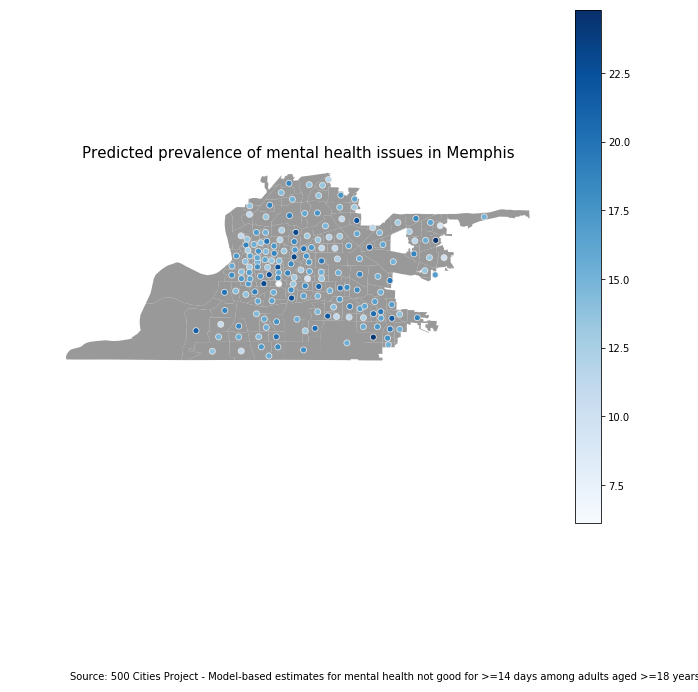

In [47]:
 # create map
fig, ax = plt.subplots(figsize=(10,12))
mem_gdf.plot(ax=ax, color='grey', alpha=0.8)
geo_mem_df.to_crs(crs).plot(column="Prediction", cmap="Blues",ax=ax, linewidth=0.8, edgecolor='0.9')

# customize
ax.set_title(('Predicted prevalence of mental health issues in {}').format("Memphis"),fontdict={"fontsize": "15", "fontweight" : "3"})
ax.annotate('Source: 500 Cities Project - Model-based estimates for mental health not good for >=14 days among adults aged >=18 years – 2016', xy=(0.1,0.03), xycoords="figure fraction", horizontalalignment="left", verticalalignment="top", fontsize="10")

# set colorbar
sm = plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=vmin_mem, vmax=vmax_mem))
sm._A = []
cbar = fig.colorbar(sm, fraction=0.046,pad=0.04)

# remove axis
ax.axis('off')
plt.savefig('mem_pred_vis.png')